<a href="https://colab.research.google.com/github/LaizaCostaa/sistema_de_recomendacao_ze_delivery/blob/main/sistema_de_recomendacao_ze_delivery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [3]:
# Local onde os arquivos estão armazenados no Google Drive
users_df = pd.read_csv('/content/drive/MyDrive/Portfólio/sistema_recomendacao_ze_delivery/ze_delivery_users.csv')
products_df = pd.read_csv('/content/drive/MyDrive/Portfólio/sistema_recomendacao_ze_delivery/ze_delivery_products.csv')
interactions_df = pd.read_csv('/content/drive/MyDrive/Portfólio/sistema_recomendacao_ze_delivery/ze_delivery_interactions.csv')

**Pre'processamento dos dados**

In [4]:
print(users_df.head())
print(products_df.head())
print(interactions_df.head())

   user_id  age gender            location signup_date
0        1   58      M       São Paulo, SP  2022-10-31
1        2   65      F  Rio de Janeiro, RJ  2024-07-05
2        3   32      M          Recife, PE  2024-02-01
3        4   24  Outro          Recife, PE  2023-11-20
4        5   52      M    Porto Alegre, RS  2023-06-17
   product_id     product_name      category  price         brand  \
0           1       Skol 255ml         Vinho  21.58        Brahma   
1           2  Coca-Cola 293ml  Refrigerante  47.87      Red Bull   
2           3   Heineken 426ml    Energético  12.50  Água Crystal   
3           4      Pepsi 207ml       Cerveja  92.86        Brahma   
4           5  Coca-Cola 448ml          Água  23.73     Coca-Cola   

   alcohol_content  
0             6.44  
1             0.00  
2             0.00  
3            10.18  
4             0.00  
   user_id  product_id interaction_type     interaction_time  rating
0        1          20         cart_add  2023-08-04 22:19:47

In [5]:
# Remover valores NaN nas interações
interactions_df.dropna(subset=['rating'], inplace=True)

# Normalizar as avaliações
interactions_df['rating_normalized'] = (interactions_df['rating'] - interactions_df['rating'].min()) / (interactions_df['rating'].max() - interactions_df['rating'].min())

Cálculo de similaridade

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import numpy as np


In [12]:
# Criar a matriz de interações
user_product_matrix = interactions_df.pivot_table(index='user_id', columns='product_id', values='rating_normalized').fillna(0)

# Fatoração da matriz com SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20, random_state=42)
user_factors = svd.fit_transform(user_product_matrix)
product_factors = svd.components_.T

# Similaridade de usuários
from sklearn.metrics.pairwise import cosine_similarity
user_similarity = cosine_similarity(user_factors)

# Similaridade de produtos
products_df['category_brand'] = products_df['category'] + " " + products_df['brand']
product_features = pd.get_dummies(products_df['category_brand'])
product_similarity = cosine_similarity(product_features)

In [14]:
# Filtrar os produtos comuns entre a matriz de interações e a matriz de similaridade de produtos
common_product_ids = user_product_matrix.columns.intersection(products_df['product_id'])

# Atualizar a matriz de interações para incluir apenas os produtos em comum
user_product_matrix = user_product_matrix[common_product_ids]

# Atualizar as características dos produtos para garantir que estejam alinhadas
product_features = product_features.loc[products_df['product_id'].isin(common_product_ids)]

# Recalcular a similaridade de produtos com base nas características filtradas
product_similarity = cosine_similarity(product_features)

In [54]:
def recommend_hybrid(user_id, n_recommendations=5):
    # Similaridade do usuário com outros usuários
    similar_users = user_similarity[user_id - 1]  # Ajustando o índice

    # Similaridade de produtos com base nas avaliações do usuário
    user_ratings = user_product_matrix.loc[user_id]

    # Certificar que as dimensões estão alinhadas
    similar_products = product_similarity.dot(user_ratings)

    # Combinação ponderada entre similaridade de usuários e produtos
    hybrid_score = 0.5 * similar_users.dot(user_product_matrix) + 0.5 * similar_products

    # Ordenar os produtos com maior pontuação
    recommended_products = np.argsort(hybrid_score)[::-1][:n_recommendations]

    # Filtrar os produtos recomendados pelos IDs em comum
    recommended_product_ids = common_product_ids[recommended_products]

    # Retornar os produtos recomendados
    return products_df[products_df['product_id'].isin(recommended_product_ids)]

# Exemplo de recomendação para o usuário de ID 1
recommendations = recommend_hybrid(user_id=1, n_recommendations=5)
print(recommendations[['product_name', 'category', 'brand']])

       product_name    category     brand
0        Skol 255ml       Vinho    Brahma
10      Pepsi 280ml     Cerveja    Brahma
18     Brahma 378ml     Cerveja    Brahma
42       Skol 423ml  Energético  Heineken
43  Coca-Cola 495ml       Vinho  Heineken


In [55]:
# Função de recomendação ajustada para verificar os IDs dos produtos recomendados
def recommend_hybrid_train(user_id, n_recommendations=5, user_weight=0.7, product_weight=0.3):
    # Verificar se o usuário existe no mapeamento
    if user_id not in user_id_to_index:
        return pd.DataFrame()  # Retornar vazio se o usuário não existir no treino

    # Obter o índice do usuário na matriz de similaridade
    user_index = user_id_to_index[user_id]

    # Calcular a similaridade do usuário
    similar_users = user_similarity_train[user_index]  # Similaridade do usuário com outros usuários
    user_ratings = user_product_matrix_train.loc[user_id]  # Avaliações do usuário

    # Calcular a similaridade de produtos
    similar_products = product_similarity_train.dot(user_ratings)

    # Combinação ponderada de similaridade de usuários e produtos
    hybrid_score = user_weight * similar_users.dot(user_product_matrix_train) + product_weight * similar_products

    # Ordenar os produtos com base no score híbrido
    recommended_products = np.argsort(hybrid_score)[::-1][:n_recommendations]

    # Filtrar os produtos recomendados pelos IDs em comum
    recommended_product_ids = common_product_ids_train[recommended_products]

    # Exibir os IDs dos produtos recomendados para verificação
    print(f"Produtos recomendados para o usuário {user_id}: {recommended_product_ids}")

    # Fazer um merge com o DataFrame de produtos para retornar as informações detalhadas
    recommendations = products_df[products_df['product_id'].isin(recommended_product_ids)]

    # Garantir que as colunas 'product_name', 'category', e 'brand' estão presentes
    return recommendations[['product_name', 'category', 'brand']]

**AVALIAÇÃO DO MODELO**

In [56]:
from sklearn.model_selection import train_test_split


In [57]:
# Dividindo o conjunto de interações em treino (80%) e teste (20%)
train_data, test_data = train_test_split(interactions_df, test_size=0.2, random_state=42)

In [58]:
#Criando a matriz de interações para o conjunto de treino
user_product_matrix_train = train_data.pivot_table(index='user_id', columns='product_id', values='rating_normalized').fillna(0)

In [59]:
# Calculando a similaridade de usuários com base no conjunto de treino
user_similarity_train = cosine_similarity(user_product_matrix_train)

# Filtrar os produtos comuns entre a matriz de interações de treino e os produtos
common_product_ids_train = user_product_matrix_train.columns.intersection(products_df['product_id'])
product_features_train = product_features.loc[products_df['product_id'].isin(common_product_ids_train)]

# Recalcular a similaridade de produtos com base nas características filtradas
product_similarity_train = cosine_similarity(product_features_train)

In [63]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [64]:
#Criar um mapeamento do `user_id` para o índice da matriz de similaridade
user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_product_matrix_train.index)}

In [65]:
# Função de recomendação com base no conjunto de treino ajustada com pesos personalizados
def recommend_hybrid_train(user_id, n_recommendations=5, user_weight=0.7, product_weight=0.3):
    # Verificar se o usuário existe no mapeamento
    if user_id not in user_id_to_index:
        return pd.DataFrame()  # Retornar vazio se o usuário não existir no treino

    # Obter o índice do usuário na matriz de similaridade
    user_index = user_id_to_index[user_id]

    # Calcular a similaridade do usuário
    similar_users = user_similarity_train[user_index]  # Similaridade do usuário com outros usuários
    user_ratings = user_product_matrix_train.loc[user_id]  # Avaliações do usuário

    # Calcular a similaridade de produtos
    similar_products = product_similarity_train.dot(user_ratings)

    # Combinação ponderada de similaridade de usuários e produtos
    hybrid_score = user_weight * similar_users.dot(user_product_matrix_train) + product_weight * similar_products

    # Ordenar os produtos com base no score híbrido
    recommended_products = np.argsort(hybrid_score)[::-1][:n_recommendations]

    # Filtrar os produtos recomendados
    recommended_product_ids = common_product_ids_train[recommended_products]

    return products_df[products_df['product_id'].isin(recommended_product_ids)]

In [66]:
# Predizer as avaliações para o conjunto de teste
predicted_ratings = []
actual_ratings = []

for _, row in test_data.iterrows():
    user_id = row['user_id']
    product_id = row['product_id']

    # Verificar se o usuário e o produto existem no conjunto de treino
    if user_id in user_product_matrix_train.index and product_id in user_product_matrix_train.columns:
        user_ratings = recommend_hybrid_train(user_id, n_recommendations=5)

        # Prevendo a avaliação com base no score do produto recomendado
        if not user_ratings.empty and product_id in user_ratings['product_id'].values:
            predicted_rating = user_ratings[user_ratings['product_id'] == product_id]['rating_normalized'].values[0]
        else:
            predicted_rating = 0  # Se o produto não for recomendado, prever como 0

        predicted_ratings.append(predicted_rating)
        actual_ratings.append(row['rating_normalized'])

# Calcular o RMSE para medir o desempenho do modelo
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print(f"RMSE do modelo: {rmse:.4f}")

RMSE do modelo: 0.6072


Otimização do modelo

In [67]:
# Testar diferentes combinações de pesos e avaliar o RMSE
for user_weight, product_weight in [(0.7, 0.3), (0.5, 0.5), (0.3, 0.7)]:
    print(f"Testando com user_weight={user_weight} e product_weight={product_weight}")

    # Recalcular recomendações e avaliar
    predicted_ratings = []
    actual_ratings = []

    for _, row in test_data.iterrows():
        user_id = row['user_id']
        product_id = row['product_id']

        # Verificar se o usuário e o produto existem no conjunto de treino
        if user_id in user_product_matrix_train.index and product_id in user_product_matrix_train.columns:
            user_ratings = recommend_hybrid_train(user_id, n_recommendations=5, user_weight=user_weight, product_weight=product_weight)

            # Prevendo a avaliação com base no score do produto recomendado
            if not user_ratings.empty and product_id in user_ratings['product_id'].values:
                predicted_rating = user_ratings[user_ratings['product_id'] == product_id]['rating_normalized'].values[0]
            else:
                predicted_rating = 0  # Se o produto não for recomendado, prever como 0

            predicted_ratings.append(predicted_rating)
            actual_ratings.append(row['rating_normalized'])

    # Calcular o RMSE para medir o desempenho do modelo
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    print(f"RMSE com user_weight={user_weight} e product_weight={product_weight}: {rmse:.4f}")

Testando com user_weight=0.7 e product_weight=0.3
RMSE com user_weight=0.7 e product_weight=0.3: 0.6072
Testando com user_weight=0.5 e product_weight=0.5
RMSE com user_weight=0.5 e product_weight=0.5: 0.6072
Testando com user_weight=0.3 e product_weight=0.7
RMSE com user_weight=0.3 e product_weight=0.7: 0.6072


**Explorando o número de componentes SVD**

In [68]:
from sklearn.decomposition import TruncatedSVD

# Escolher um número de componentes menor ou igual a 43
svd = TruncatedSVD(n_components=20, random_state=42)  # Escolha um número menor que 43
user_factors = svd.fit_transform(user_product_matrix_train)
product_factors = svd.components_.T

In [69]:
for n_components in [5, 10, 15, 20]:
    print(f"Testando com n_components={n_components}")

    # Recalcular SVD com diferentes números de componentes
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    user_factors = svd.fit_transform(user_product_matrix_train)
    product_factors = svd.components_.T


Testando com n_components=5
Testando com n_components=10
Testando com n_components=15
Testando com n_components=20


**Avaliação o RMSE**

In [70]:
for n_components in [10, 15, 20]:
    print(f"Testando com n_components={n_components}")

    # Recalcular SVD com diferentes números de componentes
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    user_factors = svd.fit_transform(user_product_matrix_train)
    product_factors = svd.components_.T

    # lógica de recomendação e avaliação
    predicted_ratings = []
    actual_ratings = []

    for _, row in test_data.iterrows():
        user_id = row['user_id']
        product_id = row['product_id']

        # Verificar se o usuário e o produto existem no conjunto de treino
        if user_id in user_product_matrix_train.index and product_id in user_product_matrix_train.columns:
            user_ratings = recommend_hybrid_train(user_id, n_recommendations=5)

            # Prevendo a avaliação com base no score do produto recomendado
            if not user_ratings.empty and product_id in user_ratings['product_id'].values:
                predicted_rating = user_ratings[user_ratings['product_id'] == product_id]['rating_normalized'].values[0]
            else:
                predicted_rating = 0  # Se o produto não for recomendado, prever como 0

            predicted_ratings.append(predicted_rating)
            actual_ratings.append(row['rating_normalized'])

    # Calcular o RMSE para medir o desempenho do modelo
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    print(f"RMSE com n_components={n_components}: {rmse:.4f}")

Testando com n_components=10
RMSE com n_components=10: 0.6072
Testando com n_components=15
RMSE com n_components=15: 0.6072
Testando com n_components=20
RMSE com n_components=20: 0.6072


In [71]:
# Função de recomendação ajustada para retornar detalhes do produto
def recommend_hybrid_train(user_id, n_recommendations=5, user_weight=0.7, product_weight=0.3):
    # Verificar se o usuário existe no mapeamento
    if user_id not in user_id_to_index:
        return pd.DataFrame()  # Retornar vazio se o usuário não existir no treino

    # Obter o índice do usuário na matriz de similaridade
    user_index = user_id_to_index[user_id]

    # Calcular a similaridade do usuário
    similar_users = user_similarity_train[user_index]  # Similaridade do usuário com outros usuários
    user_ratings = user_product_matrix_train.loc[user_id]  # Avaliações do usuário

    # Calcular a similaridade de produtos
    similar_products = product_similarity_train.dot(user_ratings)

    # Combinação ponderada de similaridade de usuários e produtos
    hybrid_score = user_weight * similar_users.dot(user_product_matrix_train) + product_weight * similar_products

    # Ordenar os produtos com base no score híbrido
    recommended_products = np.argsort(hybrid_score)[::-1][:n_recommendations]

    # Filtrar os produtos recomendados pelos IDs em comum
    recommended_product_ids = common_product_ids_train[recommended_products]

    # Fazer um merge com o DataFrame de produtos para retornar as informações detalhadas
    recommendations = products_df[products_df['product_id'].isin(recommended_product_ids)]

    # Garantir que as colunas 'product_name', 'category', e 'brand' estão presentes
    return recommendations[['product_name', 'category', 'brand']]

In [73]:
# Exemplo de recomendação para um usuário específico
user_id = 3
recommendations = recommend_hybrid_train(user_id=user_id, n_recommendations=5, user_weight=0.7, product_weight=0.3)

# Exibir as recomendações (se existirem)
print(f"Recomendações para o usuário {user_id}:")
print(recommendations)

Recomendações para o usuário 3:
          product_name      category         brand
12         Pepsi 326ml    Energético         Pepsi
19     Coca-Cola 478ml  Refrigerante      Red Bull
20  Água Crystal 470ml       Cerveja  Água Crystal
21      Heineken 268ml  Refrigerante      Heineken
48     Coca-Cola 540ml          Água        Brahma


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-79-3ed7682b2a6b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


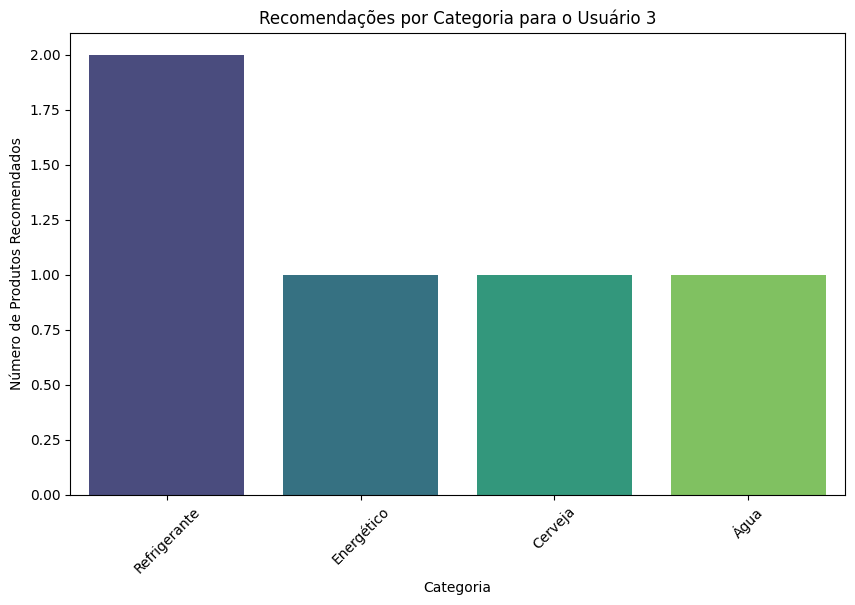

In [79]:
# Função para exibir recomendações e visualizar por categoria
def plot_recommendations(user_id, n_recommendations=5, user_weight=0.7, product_weight=0.3):
    recommendations = recommend_hybrid_train(user_id=user_id, n_recommendations=n_recommendations,
                                             user_weight=user_weight, product_weight=product_weight)

    if recommendations.empty:
        print(f"Nenhuma recomendação disponível para o usuário {user_id}")
    else:
        # Contar o número de produtos por categoria
        category_counts = recommendations['category'].value_counts()

        # Plotar as recomendações por categoria
        plt.figure(figsize=(10, 6))
        sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
        plt.title(f"Recomendações por Categoria para o Usuário {user_id}")
        plt.xlabel("Categoria")
        plt.ylabel("Número de Produtos Recomendados")
        plt.xticks(rotation=45)
        plt.show()

# Testar a visualização para um usuário específico
plot_recommendations(user_id=3, n_recommendations=5, user_weight=0.7, product_weight=0.3)

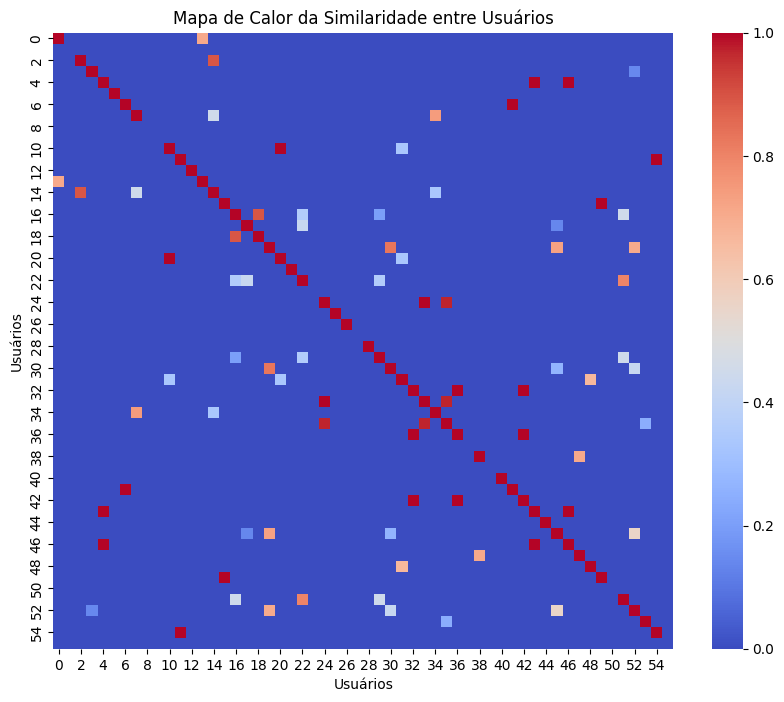

In [80]:
# Visualização da similaridade entre os usuários com heatmap
def plot_user_similarity():
    plt.figure(figsize=(10, 8))
    sns.heatmap(user_similarity_train, cmap="coolwarm", annot=False)
    plt.title("Mapa de Calor da Similaridade entre Usuários")
    plt.xlabel("Usuários")
    plt.ylabel("Usuários")
    plt.show()

# Testar a visualização de similaridade entre usuários
plot_user_similarity()

**Recomendações **